In [1]:
import sys
import os, fnmatch
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append('.')
from scipy.optimize import curve_fit
#import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [2]:
fs = 8
fsr = 12
lw = 2
matplotlib.rcParams.update({'font.size': fsr})

In [3]:
# Functions to fit data                
def exp_func(x, k):
    return  np.exp(-x/k)
def log_func(x,b):
    return -b*x
def hyp_func(x, a, b):
    return a/(x+b)                

In [4]:
#Select folders to analyse csv, as a recall you should first run pickle_to_csv_Growth in these folders
GAMMAS = ['GAMMA10R_1', 'GAMMA10R_2', 'GAMMA10R_3']

In [5]:
'''
Main part of the analysis:
- Read data from all .csv files in the selected folders.
- Calculate edge distance, and max radius.
- Bin the data according to the edge distance.
- Calculate average growth in bins.
- Fit exponential function to each data from each .csv file.
- Calculate k and r0.
- Save all data into a single Pandas DataFrame.
'''

columns = {'radialPosition':[],'cellGrowth':[],'edgeDist':[],'maxRadius':[]}
bin_columns = {'binCenter':[],'avgGrowth':[]}
df_all_data = pd.DataFrame(columns)
df_all_bins = pd.DataFrame(bin_columns)
for f in GAMMAS:
    listOfFiles = os.listdir('./'+f)
    pattern = "*.csv"
    for entry in listOfFiles:
        if fnmatch.fnmatch(entry, pattern):
            df_entry = pd.read_csv( os.path.join('.',f,entry), names=['radialPosition','cellGrowth'])
            df_entry = df_entry.dropna() #drop NaN values
            maxr = df_entry['radialPosition'].max()
            edge_dist = maxr - df_entry['radialPosition']
            df_entry['edgeDist'] = edge_dist
            bin_size = 5 # Compute binning
            nbins = int(maxr // bin_size)
            binned_gr = []
            bin_center = []
            df_bins = pd.DataFrame(bin_columns)
            for b in range(nbins):
                r0 = b*bin_size
                r1 = (b+1)*bin_size
                r0val = r0
                bin_data = df_entry[df_entry.edgeDist>=r0][df_entry.edgeDist<r1]
                avg = bin_data['cellGrowth'].mean()
                temp_bins = {'binCenter':r0val,'avgGrowth':avg}
                df_bins = df_bins.append(temp_bins,ignore_index=True )
                binned_gr.append(avg)
                bin_center.append(r0) #(r0+r1)/2)
            k ,cov = curve_fit(exp_func, bin_center, binned_gr)    
            df_entry['maxRadius'] = maxr
            df_entry['biophyGamma'] = f
            df_entry['k'] = k.mean()
            df_entry['r0'] = 1/(k.mean())
            df_bins['maxRadius'] = maxr
            df_bins['biophyGamma'] = f
            df_bins['k'] = k.mean()
            df_all_data = pd.concat([df_all_data, df_entry], ignore_index=True)
            df_all_bins = pd.concat([df_all_bins, df_bins], ignore_index=True)

<ipython-input-5-55ed35460933>:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bin_data = df_entry[df_entry.edgeDist>=r0][df_entry.edgeDist<r1]


In [6]:
# DataFrame with all data
df_all_bins

,binCenter,avgGrowth,maxRadius,biophyGamma,k
0,0.0,0.780599,201.34515,GAMMA10R_1,8.364992
1,5.0,0.549002,201.34515,GAMMA10R_1,8.364992
2,10.0,0.305025,201.34515,GAMMA10R_1,8.364992
3,15.0,0.159447,201.34515,GAMMA10R_1,8.364992
4,20.0,0.088569,201.34515,GAMMA10R_1,8.364992
...,...,...,...,...,...
1153,110.0,0.000626,136.02426,GAMMA10R_3,6.652383
1154,115.0,0.000216,136.02426,GAMMA10R_3,6.652383
1155,120.0,0.000000,136.02426,GAMMA10R_3,6.652383
1156,125.0,0.000000,136.02426,GAMMA10R_3,6.652383


In [7]:
df_all_data.describe()

,radialPosition,cellGrowth,edgeDist,maxRadius,k,r0
count,1.178398e+06,1.178398e+06,1.178398e+06,1.178398e+06,1.178398e+06,1.178398e+06
mean,1.259863e+02,6.888637e-02,7.018578e+01,1.961721e+02,8.292904e+00,1.235983e-01
std,5.415532e+01,1.709404e-01,4.850516e+01,4.273900e+01,1.467743e+00,1.761139e-02
min,2.606037e-01,0.000000e+00,0.000000e+00,7.075200e+01,6.087359e+00,7.477947e-02
25%,8.543945e+01,0.000000e+00,3.084765e+01,1.663969e+02,7.491292e+00,1.151193e-01
50%,1.266673e+02,0.000000e+00,6.056299e+01,2.011102e+02,7.997952e+00,1.250320e-01
75%,1.656828e+02,8.594295e-03,1.009385e+02,2.224738e+02,8.686637e+00,1.334883e-01
max,2.829694e+02,1.483870e+00,2.821672e+02,2.829694e+02,1.337265e+01,1.642749e-01


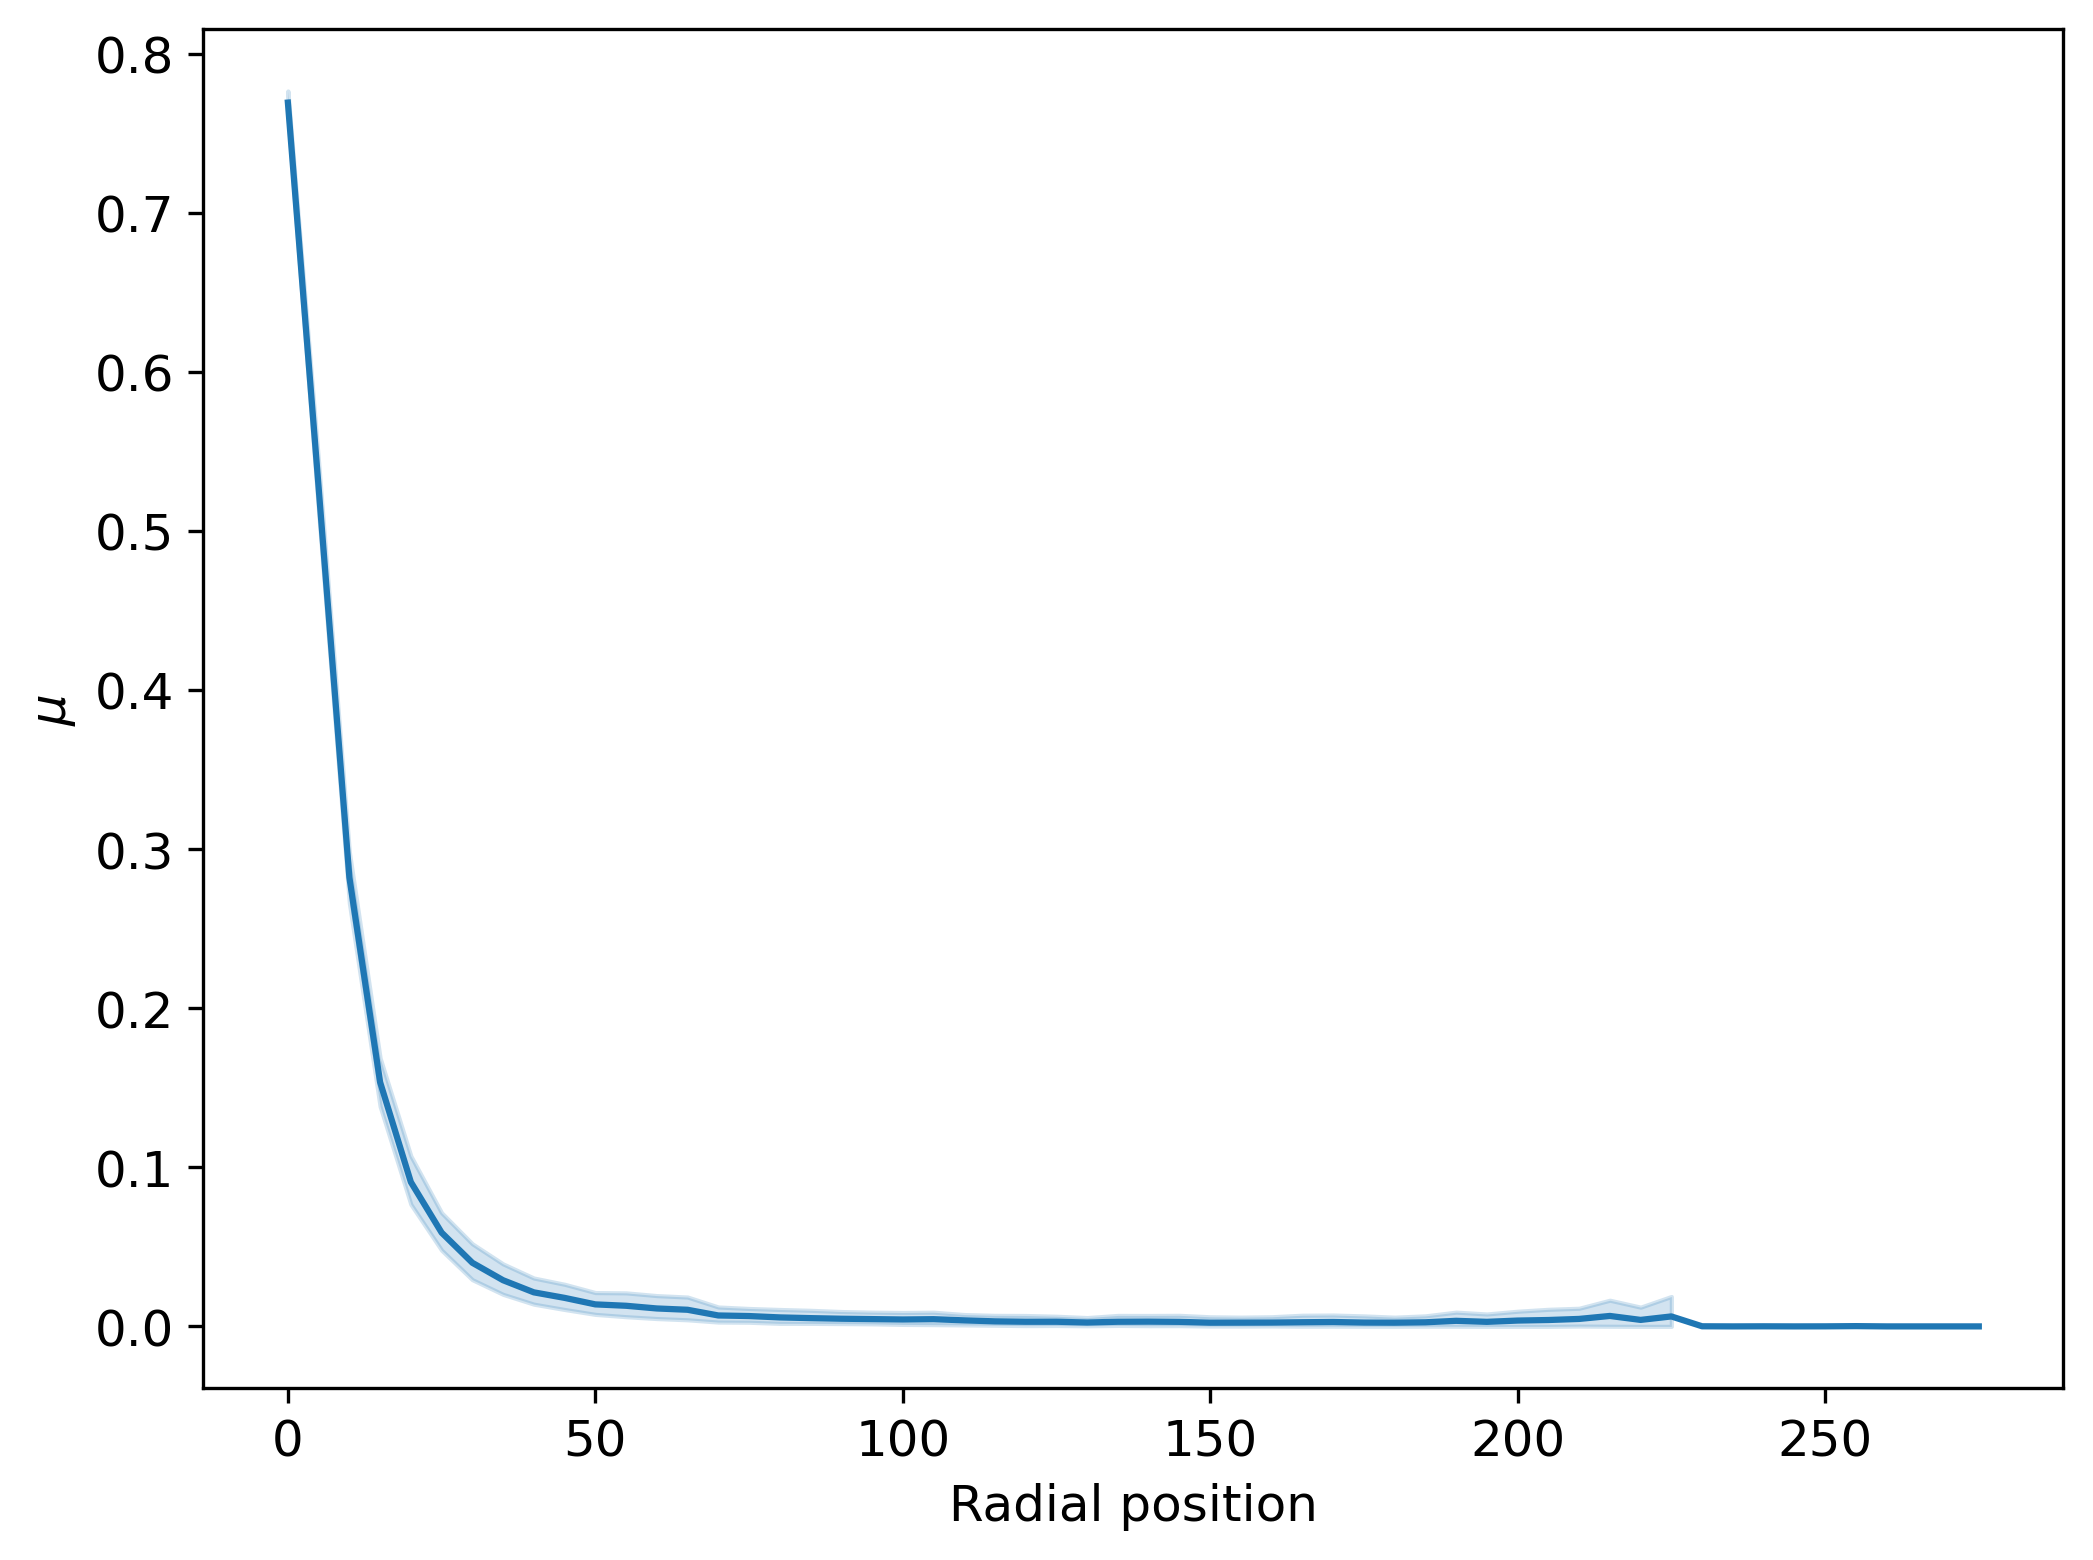

In [8]:
#Plot of average growth on bins
plt.figure(figsize=(8,6), dpi=300)
ax = sns.lineplot(x='binCenter', y='avgGrowth', data=df_all_bins)#[df_all_data['biophyGamma']=='GAMMA10'])
ax.set(xlabel='Radial position', ylabel=r'$\mu$')
plt.savefig('growth profiles.png', density=300, bbox_inches='tight', format='png')
plt.show()

In [9]:
#DataFrame with all date can be easily separated into individual sets of data.
df_gamma10_1 = df_all_data[df_all_data['biophyGamma']=='GAMMA10R_1']
df_gamma10_2 = df_all_data[df_all_data['biophyGamma']=='GAMMA10R_2']
df_gamma10_3 = df_all_data[df_all_data['biophyGamma']=='GAMMA10R_3']

In [10]:
# Calculate mean k and r0, unique() method is usefull but be care that you dont have
#  repeated numbers, it will send an error if this happens.
all_k = df_all_data['k'].unique()
all_r0 = 1/df_all_data['k'].unique()
nfiles = 0
for f in GAMMAS:
    listOfFiles = os.listdir('./'+f)
    pattern = "*.csv"
    for entry in listOfFiles:
        if fnmatch.fnmatch(entry, pattern):
            nfiles+=1
if nfiles == all_k.shape[0]:
    print('mean k = %.2f' % all_k.mean())
    print('std of mean k = %.2f' % all_k.std())
    print('mean r0 = %.2f' % all_r0.mean())
    print('std of mean r0 = %.2f' % all_r0.std())
else:
    print('ERROR: The number of files does not concide with the number of k analysed')

mean k = 8.23
std of mean k = 1.69
mean r0 = 0.13
std of mean r0 = 0.02


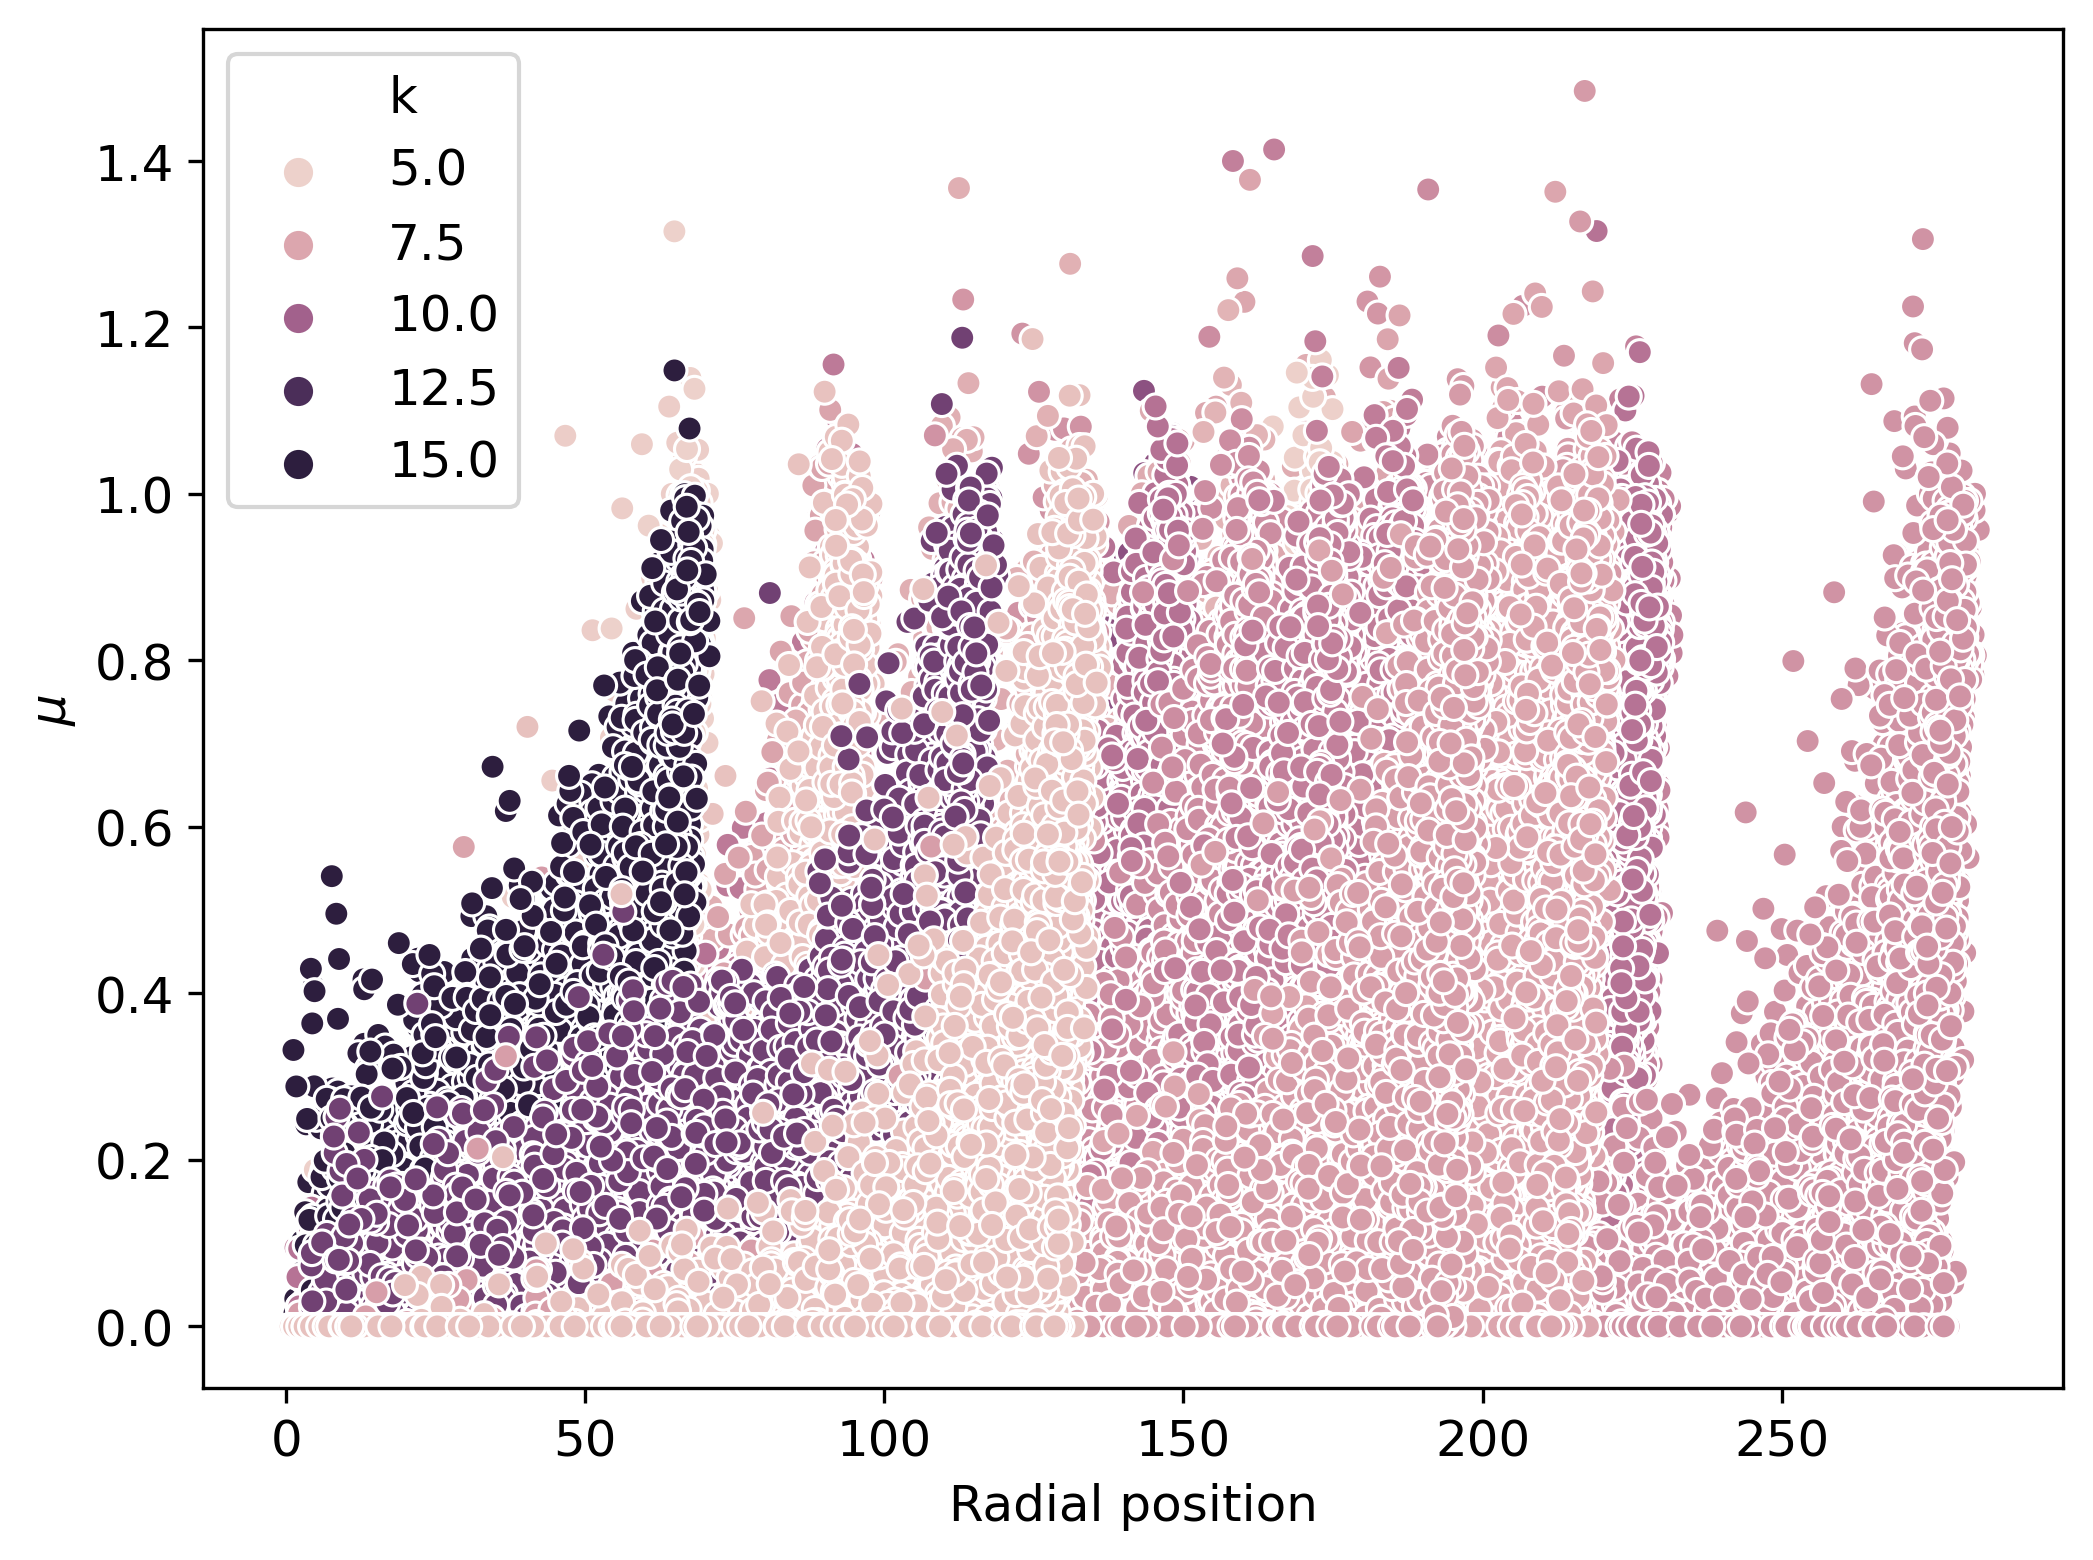

In [11]:
#In the paper we use data from colonies up to 50,000 this dont change our results or methods,
# The idea of this image is note the exponential decay is similar in all colony sizes
plt.figure(figsize=(8,6), dpi=300)
ax = sns.scatterplot(x='radialPosition', y='cellGrowth', hue='k', data=df_all_data)#[df_all_data['biophyGamma']=='GAMMA10'])
ax.set(xlabel='Radial position', ylabel=r'$\mu$')
plt.savefig('growth profiles.png', density=300, bbox_inches='tight', format='png')
plt.show()

In [ ]:
#In the paper we use data from colonies up to 50,000 this dont change our results or methods,
# The idea of this image is note the exponential decay is similar in all colony sizes
# And ordering it using edge distance instead of radial position make it clear.
plt.figure(figsize=(8,6), dpi=300)
ax = sns.scatterplot(x='edgeDist', y='cellGrowth', hue='k', data=df_all_data, )#[df_all_data['biophyGamma']=='GAMMA10'])
#ax2 = plt.plot(x, y_mean, ls='-', color='blue',linewidth=lw)
ax.set(xlabel='Distance from edge $r$', ylabel=r'$\mu$')
plt.savefig('growth profiles edge.png', density=300, bbox_inches='tight', format="png")
plt.show()

In [ ]:
# Distribution of k at different max readius
sns.scatterplot(x='maxRadius', y='k', data=df_all_data, hue='biophyGamma')

In [ ]:
# Individual description of each folder
df_all_data[df_all_data['biophyGamma']=='GAMMA10R_1'].describe()

In [ ]:
df_all_data[df_all_data['biophyGamma']=='GAMMA10R_2'].describe()

In [ ]:
df_all_data[df_all_data['biophyGamma']=='GAMMA10R_3'].describe()

In [ ]:
# Settings for Figure 2E
k_mean = all_k.mean()
k_std = all_k.std()
x = np.linspace(0,50,100)
y_mean = exp_func(x, k_mean )
y_mean_plustd = exp_func(x, k_mean+k_std )
y_mean_minstd = exp_func(x, k_mean-k_std )
bin_plot = df_all_bins[df_all_bins['binCenter']<50]

In [ ]:
#Figure 2E
plt.figure(figsize=(3,2))

fig, ax1 = plt.subplots()
# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.55, 0.5, 0.3, 0.3]
ax2 = fig.add_axes([left, bottom, width, height])
ax1.plot(bin_plot['binCenter'], bin_plot['avgGrowth'], 'o', alpha=0.6)
ax1.plot(x, y_mean, ls='-', color='blue',linewidth=lw)
ax1.set_xlabel('Distance from edge $r$')
ax1.set_ylabel(r'$\langle \mu \rangle$')
ax2.plot(x, np.log10(y_mean), ls='-', color='red',linewidth=lw)
ax2.fill_between(x, np.log10(y_mean_plustd),np.log10(y_mean_minstd) , color='red', alpha = 0.2)
ax2.set_xlabel('Distance from edge $r$')
ax2.set_ylabel(r'$log\langle \mu \rangle$')
plt.savefig('Figure2E.png', density=300, bbox_inches='tight', format="png")
plt.xlim(right=50)
plt.show()

In [ ]:
#Load data of Rmax over Time
d = np.load('r_t.npy')
t = d[0]
r_avg = d[1]
std = d[2]
r_plustd = r_avg + std
r_minstd = r_avg - std

In [ ]:
#Check loaded data
plt.figure(figsize=(3,2),dpi=300 )
fig, ax1 = plt.subplots()
ax1.plot(t, r_avg, '--', color='blue',linewidth=lw )
ax1.fill_between(t, r_plustd,r_minstd, color='blue', alpha = 0.2)
ax1.set_xlabel('Time')
ax1.set_ylabel('Colony radius $R_{max}$')
#plt.savefig('Radius vs time.png', density=300 )
plt.savefig('Data_std Fig2F.png', density=300, bbox_inches='tight', format="png")
plt.show()

In [ ]:
#Fit Rmax over time curve for times greather than 10
linfrom = 250
t_fit =t[t>10]
time_g10 = t_fit.shape[0]
r_avg_fit = r_avg[-time_g10:]
z = np.polyfit(t_fit, r_avg_fit, 1)
p = np.poly1d(z)
p_plot = p(t)

In [ ]:
#Figure 2F
plt.figure(figsize=(3,2),dpi=300 )
fig, ax1 = plt.subplots()
#ax1.fill_between(t, r_plustd,r_minstd, color='blue', alpha = 0.2)
ax1.plot(t, p_plot, ls='-', color='blue',linewidth=lw)
ax1.plot(t, r_avg, '--', color='red',linewidth=lw )
#ax1.fill_between(t, r_plustd,r_minstd, color='blue', alpha = 0.2)
ax1.set_xlabel('Time')
ax1.set_ylabel('Colony radius $R_{max}$')
#plt.savefig('Radius vs time.png', density=300 )
plt.savefig('Figure 2F.png', density=300, bbox_inches='tight', format="png")
plt.show()